In [85]:
#Zeeshan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report, cohen_kappa_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import make_scorer
from sklearn.covariance import MinCovDet
import shap
import xgboost as xgb
import datetime
from scipy import stats
import warnings

In [7]:
#Zeeshan
#Basic set for graph and warning handling
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12


In [6]:
#Zeeshan
#Loading Dataset
ds = pd.read_csv("/content/bank_transactions_data_2.csv")
ds.head()

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39


In [8]:
ds.shape

(2512, 16)

In [10]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 non-null   int64  
 14  AccountBalance          

In [15]:
#handling missing values
# Missing values
missing = ds.isnull().sum()
missing_percent = (missing / len(ds)) * 100
missing_ds = pd.DataFrame({
    'Missing Values': missing,
    'Percentage': missing_percent
})
missing_ds

,Missing Values,Percentage
TransactionID,0,0.0
AccountID,0,0.0
TransactionAmount,0,0.0
TransactionDate,0,0.0
TransactionType,0,0.0
Location,0,0.0
DeviceID,0,0.0
IP Address,0,0.0
MerchantID,0,0.0
Channel,0,0.0


In [16]:
# Duplicate rows
ds.duplicated().sum()

np.int64(0)

In [18]:
#Zeeshan
# Column type separation
id_cols = ['TransactionID', 'AccountID']
date_cols = ['TransactionDate', 'PreviousTransactionDate']

# Convert to datetime
for col in date_cols:
    if col in ds.columns:
        ds[col] = pd.to_datetime(ds[col], errors='coerce')

# Identify numeric vs categorical
numeric_cols = ds.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = ds.select_dtypes(include=['object']).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

Numeric columns: ['TransactionAmount', 'CustomerAge', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']
Categorical columns: ['TransactionID', 'AccountID', 'TransactionType', 'Location', 'DeviceID', 'IP Address', 'MerchantID', 'Channel', 'CustomerOccupation']


For each numeric feature:

-> Histogram + KDE (distribution shape).

-> Boxplot (outliers).

-> Summary stats (mean, std, min/max, skewness).

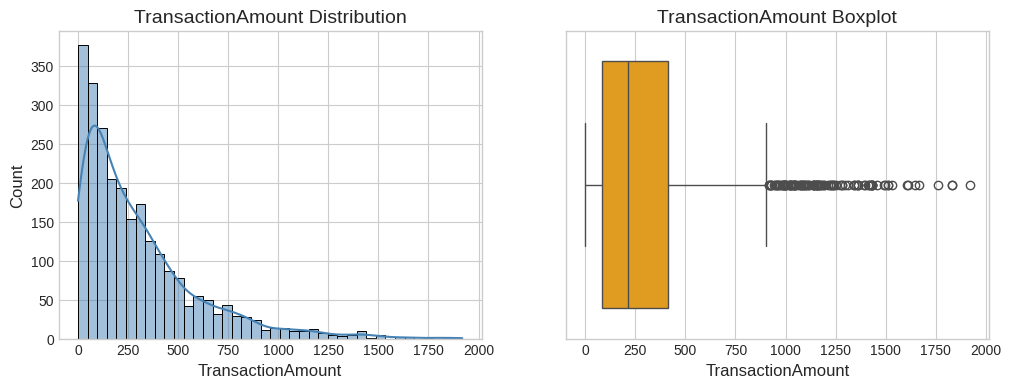

count    2512.000000
mean      297.593778
std       291.946243
min         0.260000
25%        81.885000
50%       211.140000
75%       414.527500
max      1919.110000
Name: TransactionAmount, dtype: float64
Skewness: 1.74, Kurtosis: 3.64



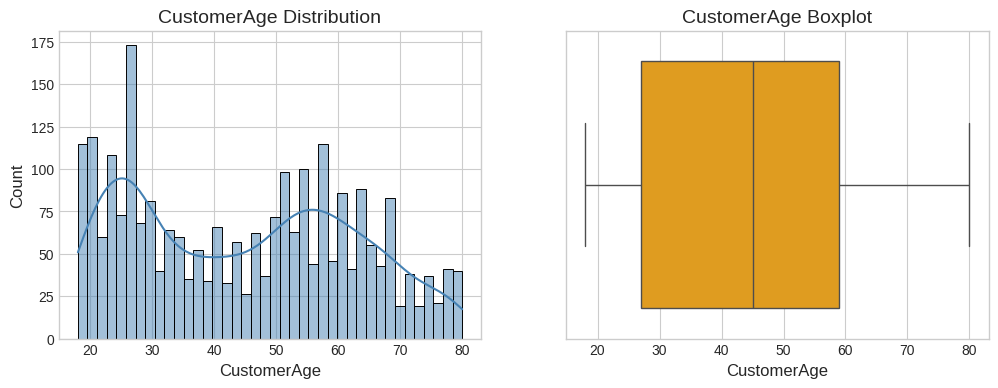

count    2512.000000
mean       44.673965
std        17.792198
min        18.000000
25%        27.000000
50%        45.000000
75%        59.000000
max        80.000000
Name: CustomerAge, dtype: float64
Skewness: 0.15, Kurtosis: -1.22



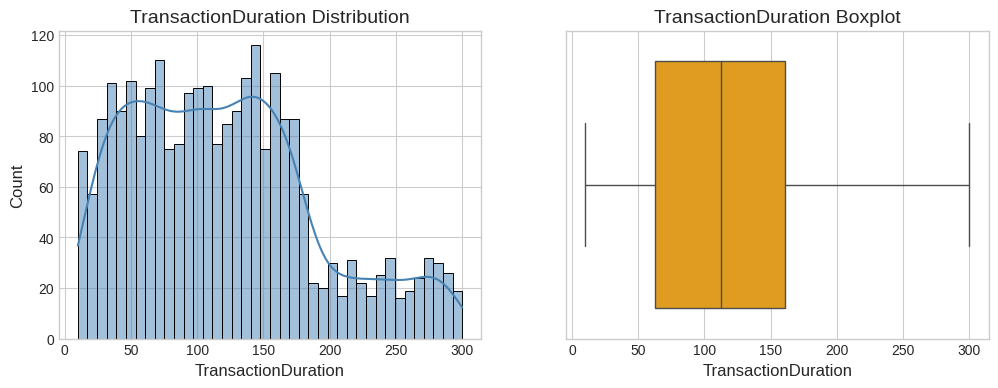

count    2512.000000
mean      119.643312
std        69.963757
min        10.000000
25%        63.000000
50%       112.500000
75%       161.000000
max       300.000000
Name: TransactionDuration, dtype: float64
Skewness: 0.60, Kurtosis: -0.26



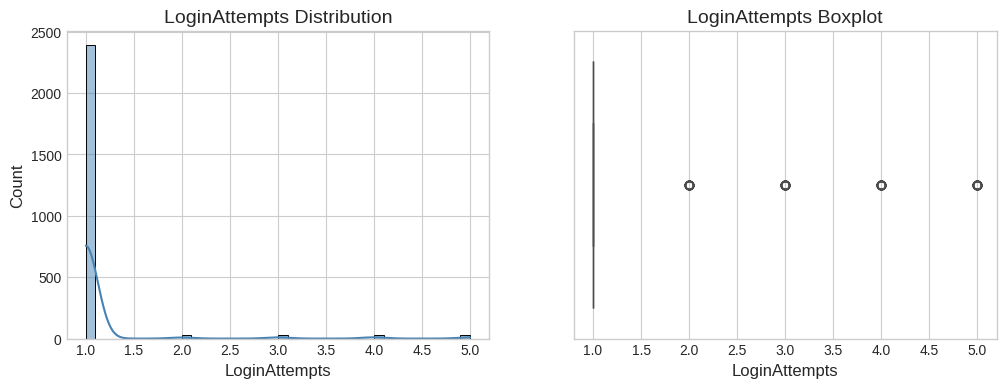

count    2512.000000
mean        1.124602
std         0.602662
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         5.000000
Name: LoginAttempts, dtype: float64
Skewness: 5.17, Kurtosis: 26.67



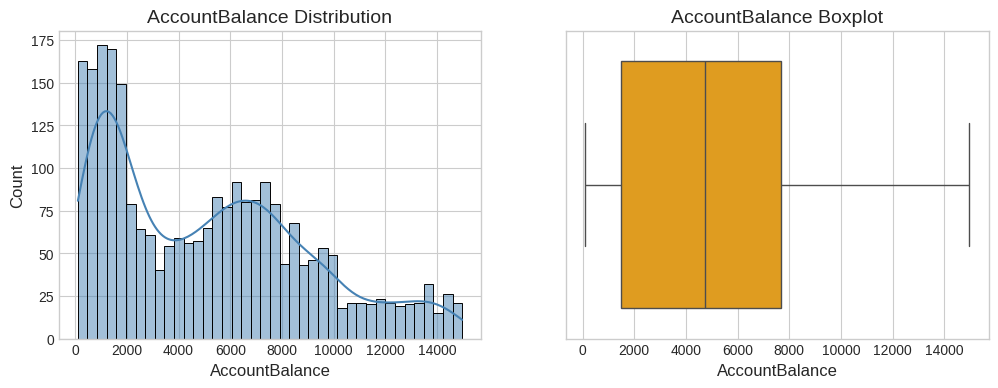

count     2512.000000
mean      5114.302966
std       3900.942499
min        101.250000
25%       1504.370000
50%       4735.510000
75%       7678.820000
max      14977.990000
Name: AccountBalance, dtype: float64
Skewness: 0.60, Kurtosis: -0.56



In [19]:
for col in numeric_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    sns.histplot(ds[col], kde=True, bins=40, ax=axes[0], color="steelblue")
    axes[0].set_title(f"{col} Distribution")
    sns.boxplot(x=ds[col], ax=axes[1], color="orange")
    axes[1].set_title(f"{col} Boxplot")
    plt.show()
    print(ds[col].describe().T)
    print(f"Skewness: {ds[col].skew():.2f}, Kurtosis: {ds[col].kurt():.2f}\n")

This section explores categorical features by plotting their frequency distributions (e.g., TransactionType, Channel, Location, CustomerOccupation, DeviceID).

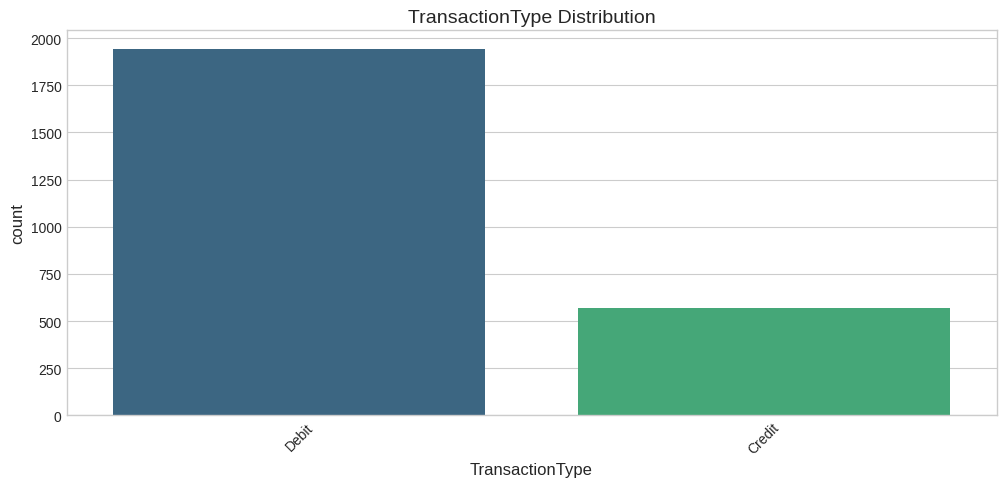

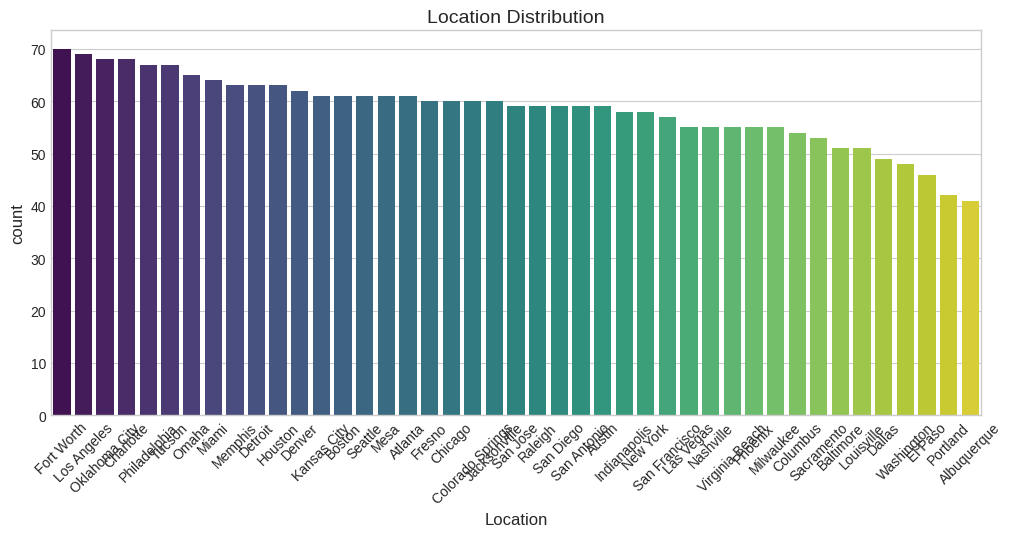

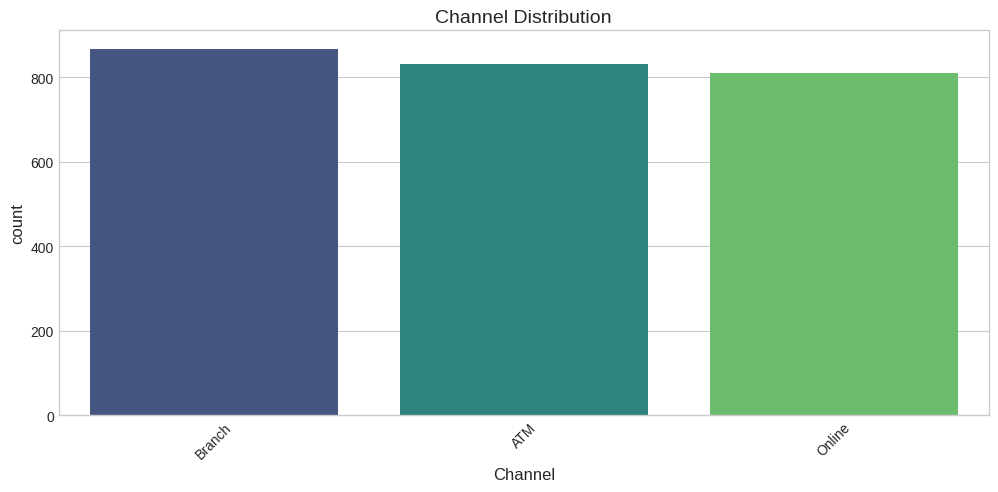

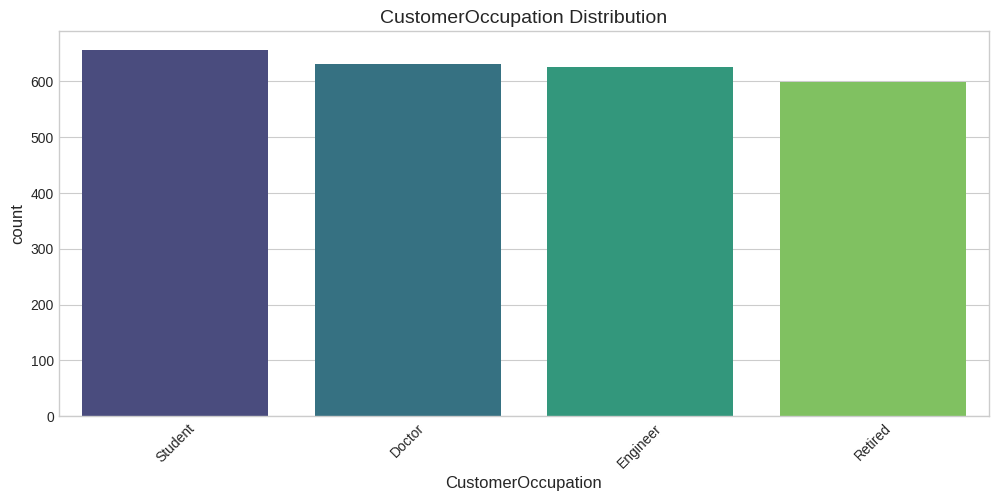

In [21]:
#Zeeshan
cat_cols = [
    'TransactionType',
    'Location',
    'Channel',
    'CustomerOccupation'
]

for col in cat_cols:
    plt.figure(figsize=(12,5))
    order = ds[col].value_counts().index
    sns.countplot(x=col, data=ds, order=order, palette="viridis")
    plt.title(f"{col} Distribution")
    plt.xticks(rotation=45)
    plt.show()

**Bivariate Analysis (Numeric vs Categorical)**

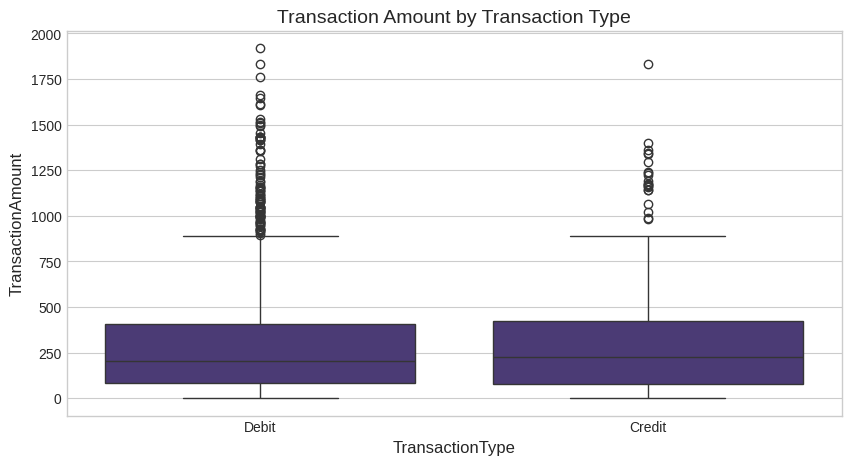

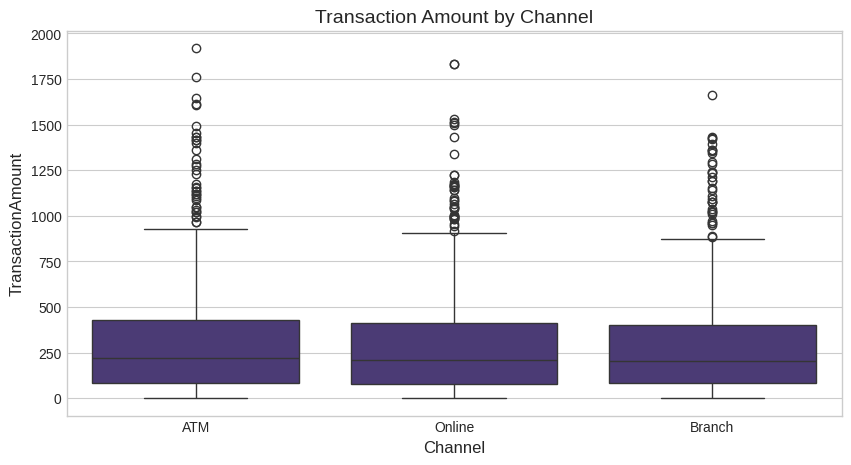

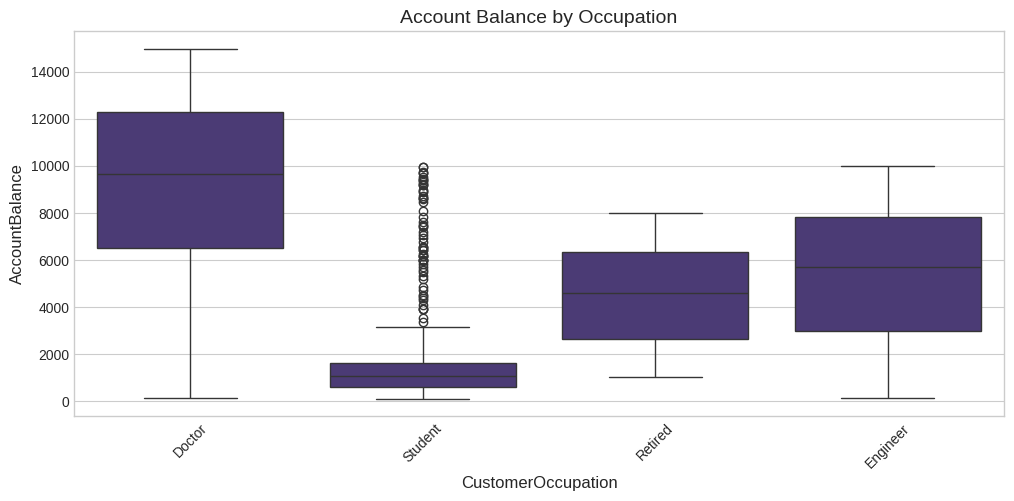

In [22]:
plt.figure(figsize=(10,5))
sns.boxplot(x='TransactionType', y='TransactionAmount', data=ds)
plt.title("Transaction Amount by Transaction Type")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x='Channel', y='TransactionAmount', data=ds)
plt.title("Transaction Amount by Channel")
plt.show()

plt.figure(figsize=(12,5))
sns.boxplot(x='CustomerOccupation', y='AccountBalance', data=ds)
plt.title("Account Balance by Occupation")
plt.xticks(rotation=45)
plt.show()

**Temporal Analysis**

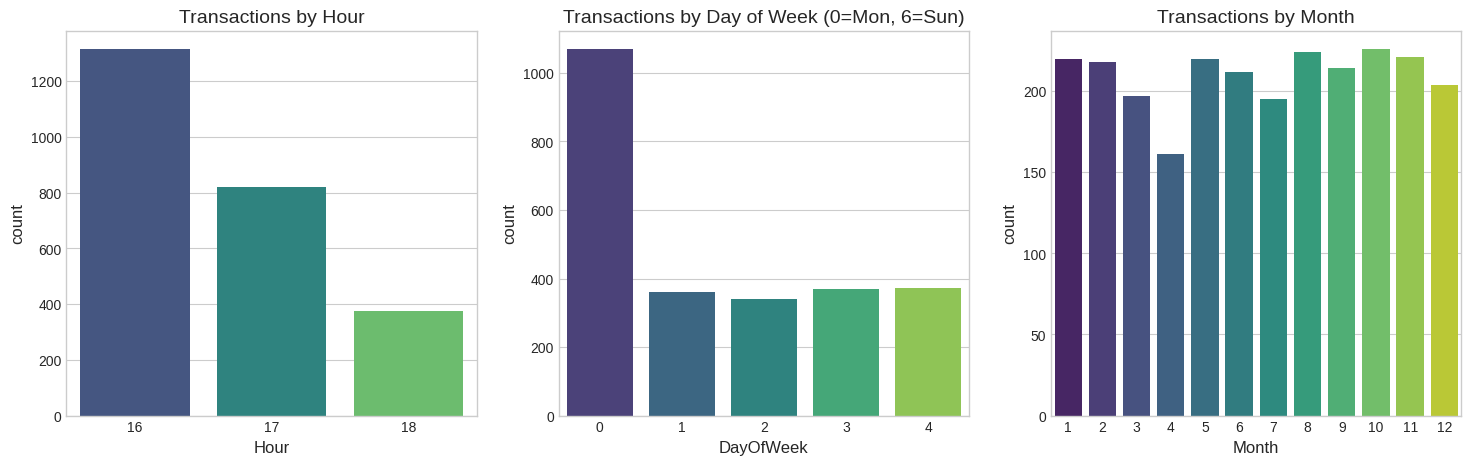

In [23]:
ds['Hour'] = ds['TransactionDate'].dt.hour
ds['DayOfWeek'] = ds['TransactionDate'].dt.dayofweek
ds['Month'] = ds['TransactionDate'].dt.month

fig, axes = plt.subplots(1,3, figsize=(18,5))
sns.countplot(x='Hour', data=ds, ax=axes[0], palette="viridis")
axes[0].set_title("Transactions by Hour")

sns.countplot(x='DayOfWeek', data=ds, ax=axes[1], palette="viridis")
axes[1].set_title("Transactions by Day of Week (0=Mon, 6=Sun)")

sns.countplot(x='Month', data=ds, ax=axes[2], palette="viridis")
axes[2].set_title("Transactions by Month")
plt.show()

**Correlation & Relationships**

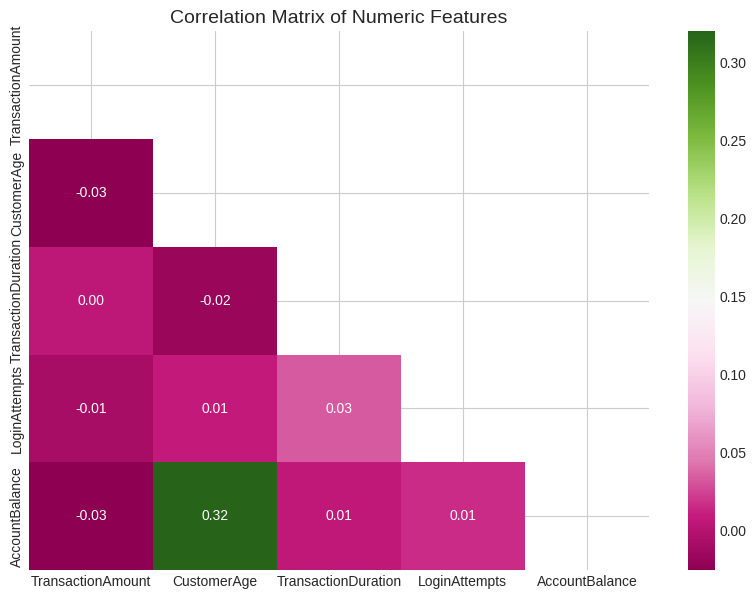

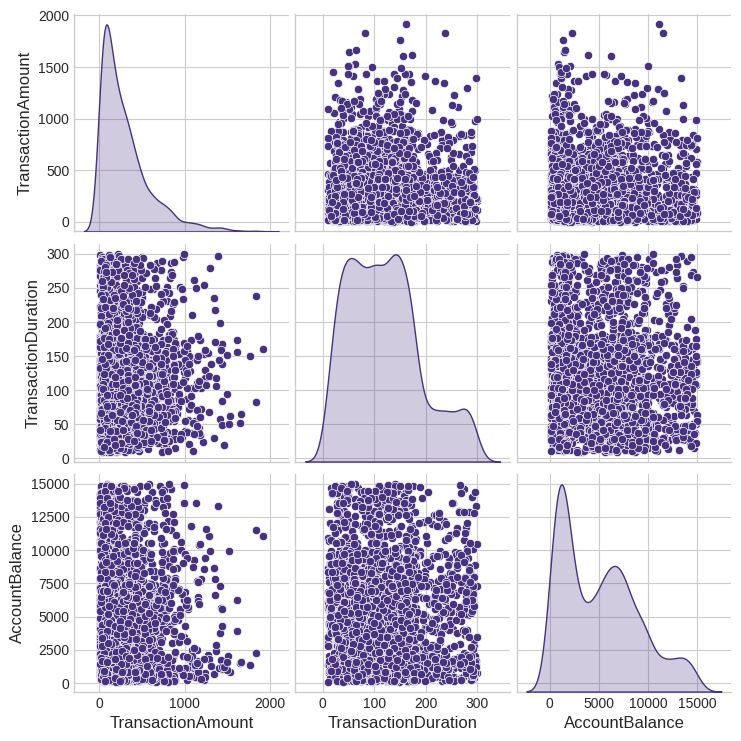

In [26]:
#Zeeshan
plt.figure(figsize=(10,7))
corr = ds[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='PiYG', fmt=".2f", mask=np.triu(corr))
plt.title("Correlation Matrix of Numeric Features")
plt.show()
sns.pairplot(ds[['TransactionAmount','TransactionDuration','AccountBalance']], diag_kind="kde")
plt.show()

***Rare Value & Outlier Analysis***
For each column, values with |Z| > 3 are counted as outliers,

the results show how many unusual values exist in each feature and what percentage of the dataset they represent.

For example, TransactionAmount has 48 outliers (1.91%) and LoginAttempts has 95 (3.78%), while other features show no extreme values.

This helps identify suspicious or irregular behavior in the data.

In [28]:
for col in numeric_cols:
    z_scores = stats.zscore(ds[col])
    outliers = (np.abs(z_scores) > 3).sum()
    print(f"{col}: {outliers} outliers ({outliers/len(ds)*100:.2f}%)")

TransactionAmount: 48 outliers (1.91%)
CustomerAge: 0 outliers (0.00%)
TransactionDuration: 0 outliers (0.00%)
LoginAttempts: 95 outliers (3.78%)
AccountBalance: 0 outliers (0.00%)


##Feature Extraction

**Drop irrelevant columns**

We remove columns that don’t carry predictive value (IDs, dates, pre-calculated scores) to avoid data leakage and noise.

In [29]:
ds_model = ds.copy()
drop_cols = [
    "TransactionID", "AccountID", "TransactionDate",
    "PreviousTransactionDate", "IP Address", "Amount_Z_Score"
]
ds_model.drop(columns=[c for c in drop_cols if c in ds_model.columns], inplace=True)
ds_model

,TransactionAmount,TransactionType,Location,DeviceID,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,Hour,DayOfWeek,Month
0,14.09,Debit,San Diego,D000380,M015,ATM,70,Doctor,81,1,5112.21,16,1,4
1,376.24,Debit,Houston,D000051,M052,ATM,68,Doctor,141,1,13758.91,16,1,6
2,126.29,Debit,Mesa,D000235,M009,Online,19,Student,56,1,1122.35,18,0,7
3,184.50,Debit,Raleigh,D000187,M002,Online,26,Student,25,1,8569.06,16,4,5
4,13.45,Credit,Atlanta,D000308,M091,Online,26,Student,198,1,7429.40,17,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2507,856.21,Credit,Colorado Springs,D000625,M072,Branch,33,Doctor,109,1,12690.79,17,2,4
2508,251.54,Debit,Tucson,D000410,M029,Branch,48,Doctor,177,1,254.75,17,2,3
2509,28.63,Debit,San Diego,D000095,M087,Branch,56,Retired,146,1,3382.91,17,0,8
2510,185.97,Debit,Denver,D000634,M041,Online,23,Student,19,1,1776.91,16,4,2


##Create new features

**Basic new features**

In [30]:
# Ratio: Transaction amount / average per transaction type
avg_tx_amount_by_type = ds_model.groupby("TransactionType")["TransactionAmount"].transform("mean")
ds_model["Amount_to_AvgByType_Ratio"] = ds_model["TransactionAmount"] / avg_tx_amount_by_type

# Device transaction count
device_tx_count = ds_model.groupby("DeviceID").size().reset_index(name="DeviceTxCount")
df_model = ds_model.merge(device_tx_count, on="DeviceID", how="left")

**Encode categorical features**

In [31]:
categorical_cols = ds_model.select_dtypes(include=["object"]).columns.tolist()
le = LabelEncoder()
for col in categorical_cols:
    ds_model[col] = le.fit_transform(ds_model[col])

## Scale numerical features

In [36]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(ds_model)
df_scaled_df = pd.DataFrame(df_scaled, columns=ds_model.columns)

print(f"Final dataset shape: {ds_model.shape}")

Final dataset shape: (2512, 15)


##Dimensionality Reduction (PCA + t-SNE)

We first applied PCA to understand how much variance each principal component explains. The cumulative variance plot shows that information can be compressed into fewer dimensions while retaining most variability. Then, we used t-SNE for non-linear dimensionality reduction and visualized transactions in 2D space. This plot helps reveal potential clusters or separations between normal and anomalous transactions, which are often hidden in high-dimensional space.

**Principal Component Analysis (PCA)**

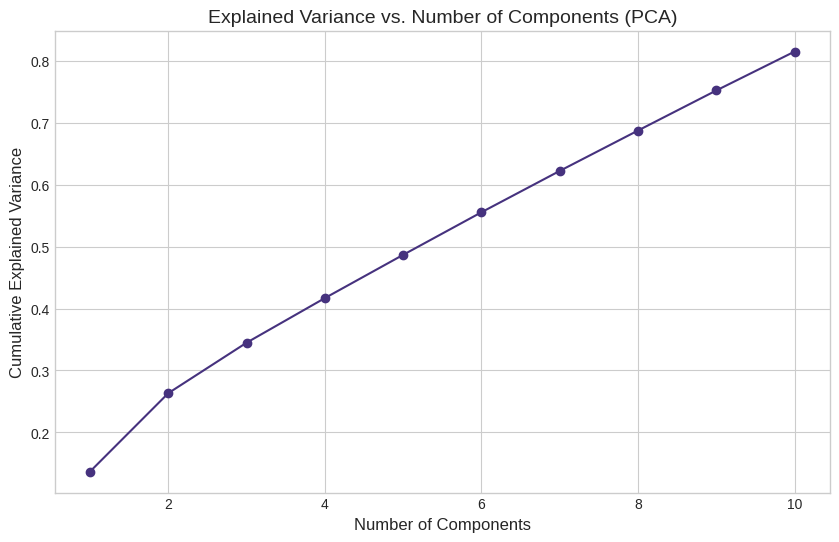

In [37]:
n_components = min(10, len(df_model.columns))
pca = PCA(n_components=n_components, random_state=42)
pca_result = pca.fit_transform(df_scaled)

explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_var) + 1), cumulative_var, marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Components (PCA)")
plt.grid(True)
plt.show()


**Anomaly Detection Models**

In [38]:
#Zeeshan
def plot_anomalies(tsne_results, df, label_col, title):
    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        x=tsne_results[:, 0],
        y=tsne_results[:, 1],
        hue=df[label_col],
        palette='coolwarm',
        alpha=0.7
    )
    plt.title(title)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend(title="Anomaly", loc='upper right')
    plt.show()

**Minimum Covariance Determinant (MCD)**

In [39]:
# Fit Minimum Covariance Determinant (robust covariance estimation)
mcd = MinCovDet(support_fraction=0.75, random_state=42)
mcd.fit(df_scaled_df)

# Compute Mahalanobis distance to the robust center
mahal_dist = mcd.mahalanobis(df_scaled_df)

# Threshold: 97.5th percentile of distances
threshold = np.percentile(mahal_dist, 97.5)

#  Mark anomalies (1 = anomaly, 0 = normal)
df_model["MCD_Anomaly"] = (mahal_dist > threshold).astype(int)
df_model["MCD_Score"] = mahal_dist



Applying t-SNE for visualization...


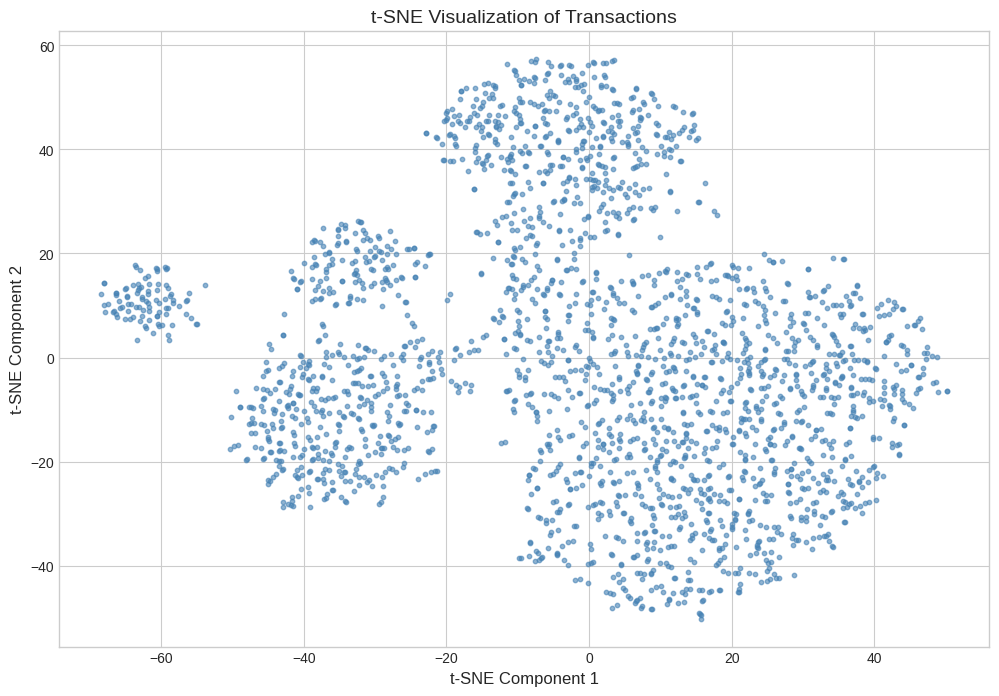

In [42]:
# t-SNE
print("\nApplying t-SNE for visualization...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(df_scaled)

plt.figure(figsize=(12, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=10, alpha=0.6, c="steelblue")
plt.title("t-SNE Visualization of Transactions")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


**Isolation Forest**

In [40]:
param_grid = {
    "n_estimators": [100, 200],       # number of trees
    "contamination": [0.01, 0.02, 0.05],  # anomaly proportion
    "max_samples": [100, "auto"]      # samples per tree
}

iso_forest = IsolationForest(random_state=42)

grid_search = GridSearchCV(
    estimator=iso_forest,             # model
    param_grid=param_grid,            # parameters to try
    cv=3,
    scoring="neg_mean_squared_error",
    verbose=0
)

grid_search.fit(df_scaled_df)
print("Best Isolation Forest parameters:", grid_search.best_params_)

best_iso_forest = grid_search.best_estimator_
df_model["IF_Anomaly"] = best_iso_forest.predict(df_scaled_df)   # labels
df_model["IF_Score"] = best_iso_forest.decision_function(df_scaled_df)  # scores
df_model["IF_Anomaly"] = df_model["IF_Anomaly"].map({1: 0, -1: 1})


Best Isolation Forest parameters: {'contamination': 0.01, 'max_samples': 100, 'n_estimators': 100}


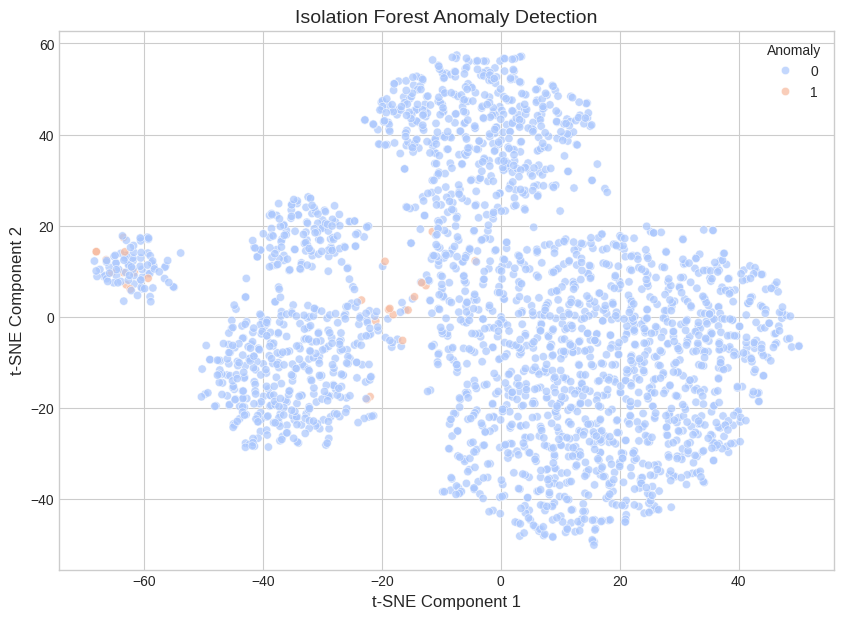

In [43]:
plot_anomalies(tsne_results, df_model, 'IF_Anomaly', "Isolation Forest Anomaly Detection")


**t-SNE Visualization**

t-SNE (t-distributed Stochastic Neighbor Embedding) is used for non-linear dimensionality reduction. It’s especially effective for visualizing clusters in 2D space.

**Anomaly Detection Models**

Now that the dataset is cleaned, features engineered, and scaled, we can apply unsupervised algorithms to detect unusual transaction patterns. Since we don’t have fraud labels, the task is purely anomaly detection.

In [44]:
#Zeeshan
def plot_anomalies(tsne_results, df, label_col, title):
    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        x=tsne_results[:, 0],
        y=tsne_results[:, 1],
        hue=df[label_col],
        palette='coolwarm',
        alpha=0.7
    )
    plt.title(title)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend(title="Anomaly", loc='upper right')
    plt.show()

**Minimum Covariance Determinant (MCD)**

Minimum Covariance Determinant (MCD) is a robust covariance estimator that fits an ellipsoidal boundary around the most central part of the data, making it resistant to outliers. We use it because the method is well-suited for data that is approximately Gaussian and more robust than the standard covariance or Elliptic Envelope. The parameter support_fraction=0.75 ensures stability by focusing on 75% of the most central points, while the 97.5th percentile of Mahalanobis distances is chosen as the cutoff to flag the most extreme points as anomalies.

In [45]:
# Fit Minimum Covariance Determinant (robust covariance estimation)
mcd = MinCovDet(support_fraction=0.75, random_state=42)
mcd.fit(df_scaled_df)

# Compute Mahalanobis distance to the robust center
mahal_dist = mcd.mahalanobis(df_scaled_df)

# Threshold: 97.5th percentile of distances
threshold = np.percentile(mahal_dist, 97.5)

#  Mark anomalies (1 = anomaly, 0 = normal)
df_model["MCD_Anomaly"] = (mahal_dist > threshold).astype(int)
df_model["MCD_Score"] = mahal_dist


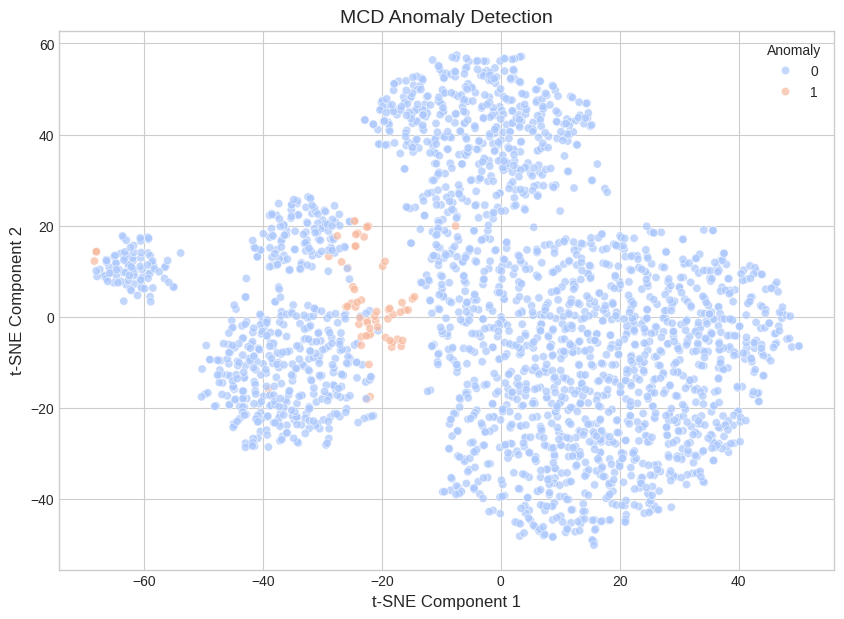

In [46]:
# MCD
plot_anomalies(tsne_results, df_model, 'MCD_Anomaly', "MCD Anomaly Detection")


**Isolation Forest**

Isolation Forest isolates anomalies by randomly partitioning the feature space. Anomalies are easier to separate because they’re rare and different.

In [56]:
param_grid = {
    "n_estimators": [100, 200],       # number of trees
    "contamination": [0.01, 0.02, 0.05],  # anomaly proportion
    "max_samples": [100, "auto"]      # samples per tree
}

iso_forest = IsolationForest(random_state=42)

grid_search = GridSearchCV(
    estimator=iso_forest,             # model
    param_grid=param_grid,            # parameters to try
    cv=3,
    scoring="neg_mean_squared_error",
    verbose=0
)

grid_search.fit(df_scaled_df)
print("Best Isolation Forest parameters:", grid_search.best_params_)

best_iso_forest = grid_search.best_estimator_
df_model["IF_Anomaly"] = best_iso_forest.predict(df_scaled_df)   # labels
df_model["IF_Score"] = best_iso_forest.decision_function(df_scaled_df)  # scores
df_model["IF_Anomaly"] = df_model["IF_Anomaly"].map({1: 0, -1: 1})


Best Isolation Forest parameters: {'contamination': 0.01, 'max_samples': 100, 'n_estimators': 100}


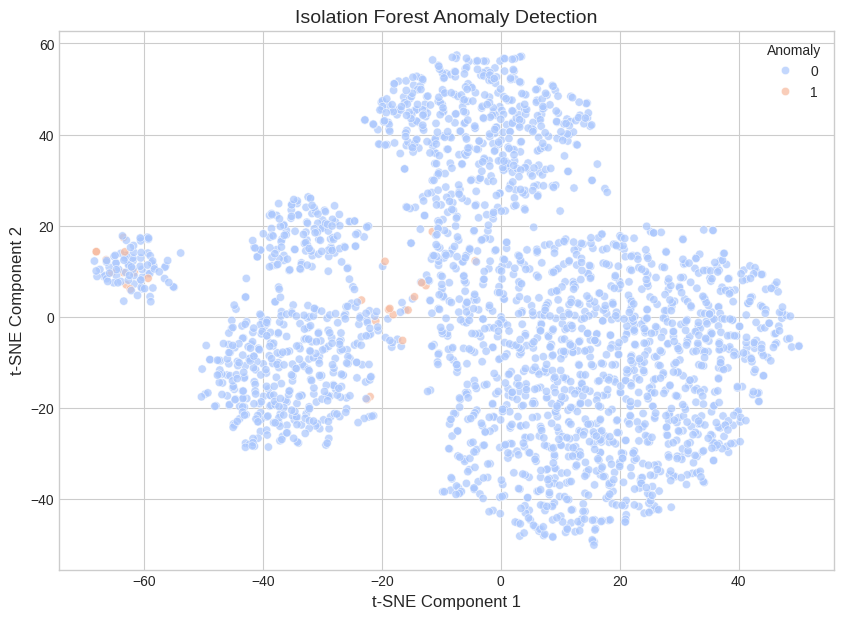

In [49]:
# Isolation Forest
plot_anomalies(tsne_results, df_model, 'IF_Anomaly', "Isolation Forest Anomaly Detection")


**Local Outlier Factor (LOF)**

We implemented Local Outlier Factor (LOF) with hyperparameter tuning using a custom wrapper to make it compatible with GridSearchCV. A silhouette score was used as the evaluation metric to find the best settings for neighborhood size, contamination rate, and distance metric. The optimized LOF model flags anomalies, and results are visualized on the t-SNE projection to highlight how well the method separates suspicious transactions.

In [73]:
# Custom wrapper to make LOF compatible with GridSearchCV
class LOFWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, n_neighbors=20, contamination=0.05, metric="euclidean"):
        self.n_neighbors = n_neighbors
        self.contamination = contamination
        self.metric = metric
        self.model = None

    def fit(self, X, y=None):
        self.model = LocalOutlierFactor(
            n_neighbors=self.n_neighbors,
            contamination=self.contamination,
            metric=self.metric
        )
        self.labels_ = self.model.fit_predict(X)
        return self

    def predict(self, X):
        # Use fitted labels for training set
        return self.labels_

# Custom scorer: silhouette score (higher = better)
def lof_scorer(estimator, X, y=None):
    labels = estimator.fit(X).labels_
    if len(set(labels)) > 1:  # avoid invalid silhouette case
        return silhouette_score(X, labels)
    else:
        return -1

scorer = make_scorer(lof_scorer, greater_is_better=True)

# GridSearchCV for LOF
param_grid = {
    'n_neighbors': [10, 20, 30, 50],
    'contamination': [0.01, 0.02, 0.05, 0.1],
    'metric': ['euclidean', 'manhattan']
}
n_samples = len(df_scaled_df)
grid_search = GridSearchCV(
    estimator=LOFWrapper(),
    param_grid=param_grid,
    scoring=scorer,
    # cv=[(slice(None), slice(None))],  # trick for unsupervised CV
    cv = [(np.arange(n_samples), np.arange(n_samples))],
    verbose=1
)
df_scaled_df.index

grid_search.fit(df_scaled_df.to_numpy())

print("Best LOF parameters:", grid_search.best_params_)

best_lof = grid_search.best_estimator_
df_model['LOF_Anomaly'] = np.where(best_lof.labels_ == -1, 1, 0)


Fitting 1 folds for each of 32 candidates, totalling 32 fits
Best LOF parameters: {'contamination': 0.01, 'metric': 'euclidean', 'n_neighbors': 10}


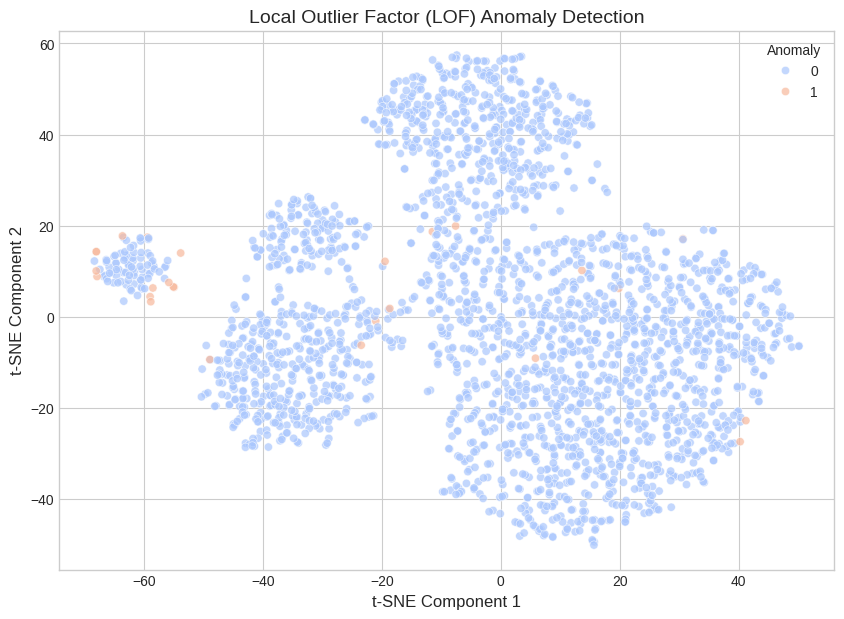

In [74]:
#anomaly count
plot_anomalies(tsne_results, df_model, 'LOF_Anomaly', "Local Outlier Factor (LOF) Anomaly Detection")


**One-Class SVM**

Learns the boundary of “normal” transactions; everything outside is treated as anomaly.**bold text**

In [75]:
ocsvm = OneClassSVM(nu=0.05, kernel="rbf", gamma="auto")
df_model['OCSVM_Anomaly'] = ocsvm.fit_predict(df_scaled_df)
df_model['OCSVM_Score'] = ocsvm.decision_function(df_scaled_df)

# Map: -1 → anomaly (1), 1 → normal (0)
df_model['OCSVM_Anomaly'] = df_model['OCSVM_Anomaly'].map({1: 0, -1: 1})


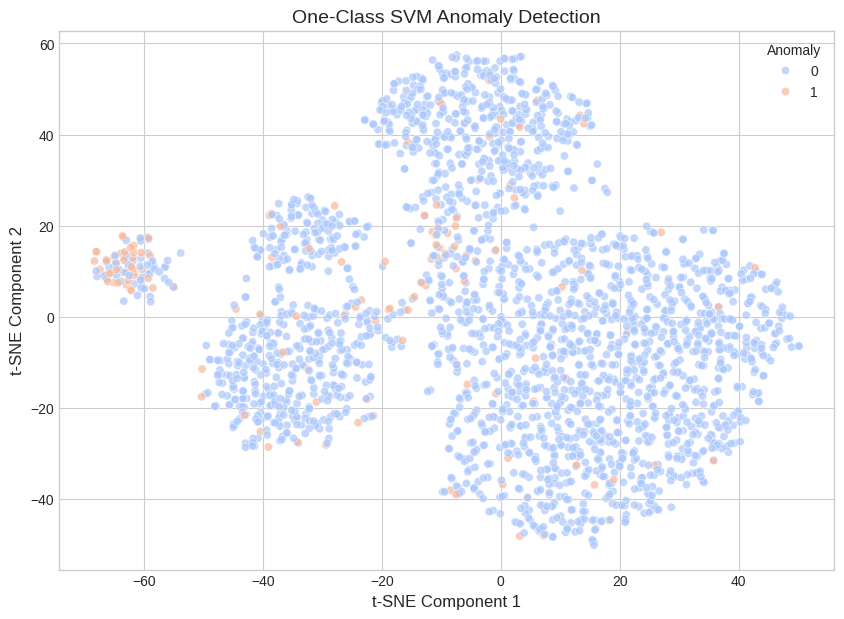

In [76]:
plot_anomalies(tsne_results, df_model, 'OCSVM_Anomaly', "One-Class SVM Anomaly Detection")

**Ensemble Voting**

Since each method has its own bias, we can combine them with majority voting.

Ensemble Anomalies (majority vote): 36 (1.43%)


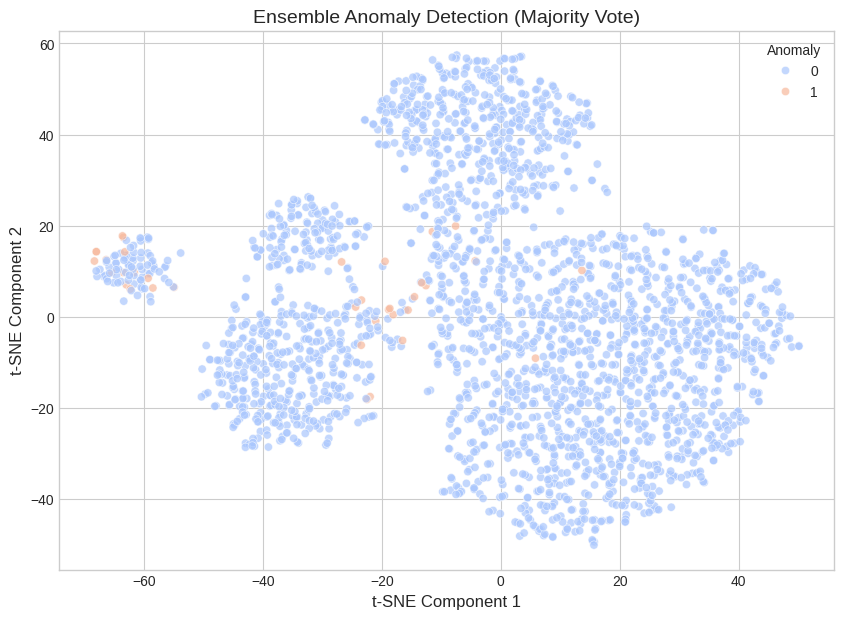

In [77]:
# Ensemble anomaly detection (majority vote)
df_model['Ensemble_Anomaly'] = (
    (df_model['IF_Anomaly'] + df_model['LOF_Anomaly'] + df_model['OCSVM_Anomaly']+df_model['MCD_Anomaly']) >= 2
).astype(int)

print(f"Ensemble Anomalies (majority vote): {df_model['Ensemble_Anomaly'].sum()} "
      f"({df_model['Ensemble_Anomaly'].mean()*100:.2f}%)")

# Visualization
plot_anomalies(tsne_results, df_model, 'Ensemble_Anomaly',
               "Ensemble Anomaly Detection (Majority Vote)")


**SHAP Analysis**

We use SHAP to interpret how different features drive anomaly detection in the XGBoost model trained on ensemble labels. The analysis shows that the most powerful signals come from transaction amounts and their deviation from typical spending patterns, which directly highlight unusual financial behavior. Login attempts also play a critical role, pointing to potential fraud through abnormal access patterns. Account-related attributes such as balance levels and transaction type further distinguish suspicious from legitimate operations, while merchant, device, and location details add valuable context for identifying risky transactions. Temporal and demographic features have a smaller but still meaningful impact, refining detection in specific scenarios.

From a business perspective, this means the system effectively captures anomalies tied to unusual spending, suspicious login activity, and irregular account behavior, which are among the most relevant indicators of fraud in financial transactions.

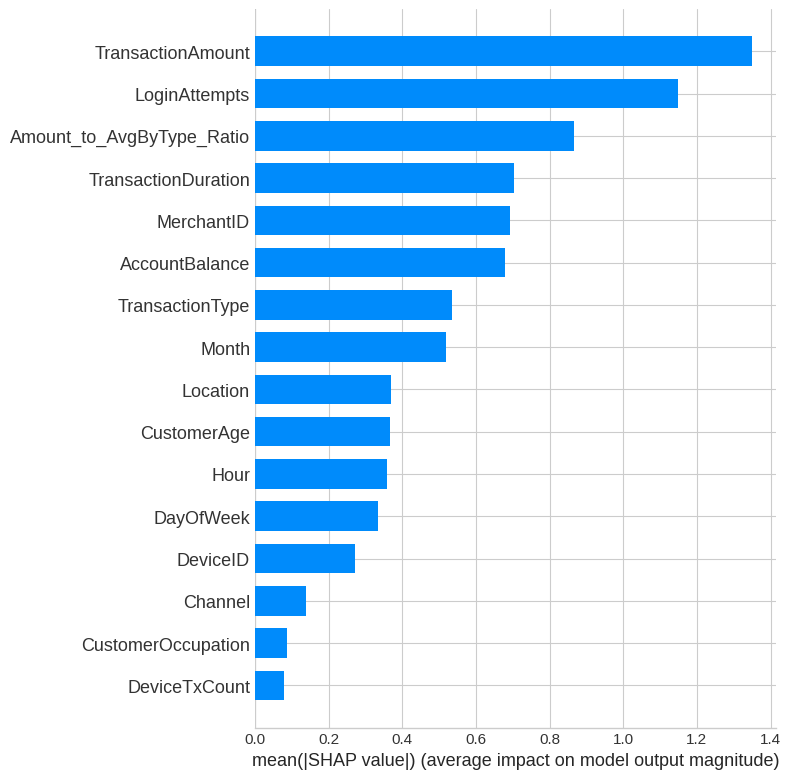

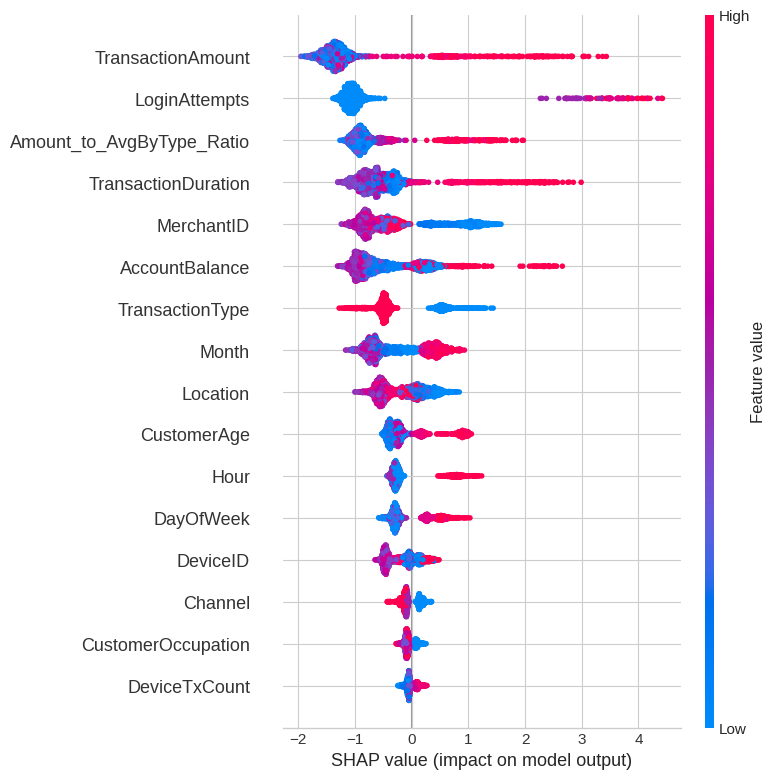

In [82]:
# Define features and labels
X = df_model.drop([
    'IF_Anomaly','LOF_Anomaly','MCD_Score','MCD_Anomaly',
    'OCSVM_Anomaly','IF_Score','OCSVM_Score','Ensemble_Anomaly'
], axis=1)
y = df_model['Ensemble_Anomaly']

# Encode categorical features in X
categorical_cols_X = X.select_dtypes(include=["object"]).columns.tolist()
le = LabelEncoder()
for col in categorical_cols_X:
    X[col] = le.fit_transform(X[col])


# Train XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X, y)

# === SHAP values ===
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)

# Summary plot
shap.summary_plot(shap_values, X, plot_type="bar")

# Detailed beeswarm plot
shap.summary_plot(shap_values, X)

### Decision Tree for Anomaly Detection Rules
We train a simple Decision Tree on the ensemble anomaly labels to extract human-readable rules for anomaly detection. Unlike black-box models such as Isolation Forest or One-Class SVM, this tree produces transparent if-then conditions that can be directly applied or validated by business experts.

The rules reveal that anomalies are often driven by a combination of unusual transaction amounts and suspicious login behavior. For instance, transactions with high login attempts and atypical TransactionAmount or Amount_to_AvgByType_Ratio are frequently classified as anomalies. Similarly, abnormal patterns in AccountBalance, DeviceTxCount, or MerchantID often separate fraudulent from normal activity.

In practice, this means the model highlights red flags such as repeated failed logins, abnormal spending relative to usual patterns, and inconsistent account balances. These decision rules provide a clear and interpretable framework for fraud analysts to understand why certain transactions are flagged, bridging the gap between machine learning detection and business validation.

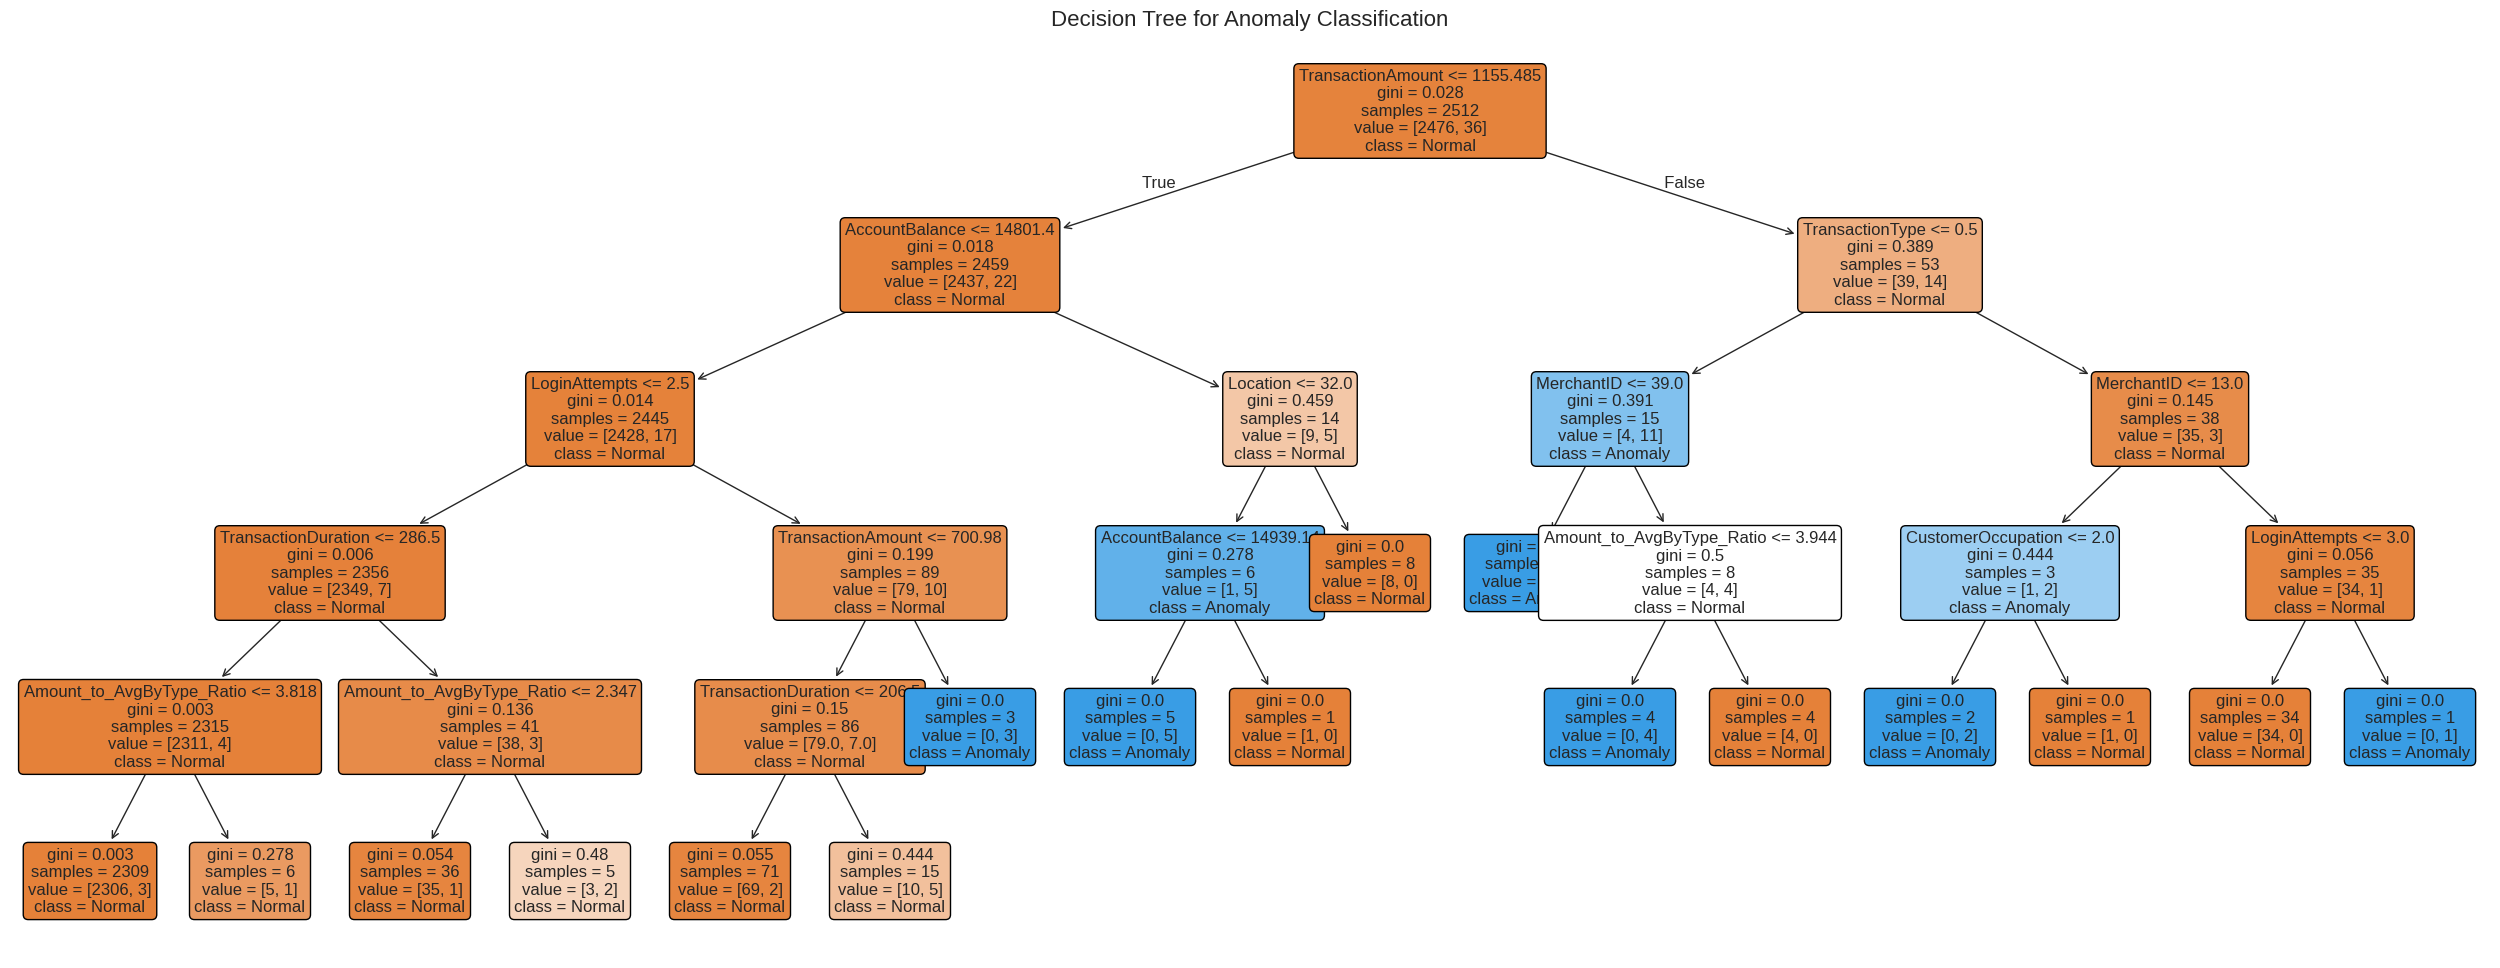


Decision Rules for Identifying Anomalies:

|--- TransactionAmount <= 1155.49
|   |--- AccountBalance <= 14801.40
|   |   |--- LoginAttempts <= 2.50
|   |   |   |--- TransactionDuration <= 286.50
|   |   |   |   |--- Amount_to_AvgByType_Ratio <= 3.82
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Amount_to_AvgByType_Ratio >  3.82
|   |   |   |   |   |--- class: 0
|   |   |   |--- TransactionDuration >  286.50
|   |   |   |   |--- Amount_to_AvgByType_Ratio <= 2.35
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Amount_to_AvgByType_Ratio >  2.35
|   |   |   |   |   |--- class: 0
|   |   |--- LoginAttempts >  2.50
|   |   |   |--- TransactionAmount <= 700.98
|   |   |   |   |--- TransactionDuration <= 206.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- TransactionDuration >  206.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- TransactionAmount >  700.98
|   |   |   |   |--- class: 1
|   |--- AccountBalance >  14801.40
|   |   |--- Location <= 32.00
|   |   |

In [83]:
# Train simple decision tree
# Encode categorical features in X
categorical_cols_X = X.select_dtypes(include=["object"]).columns.tolist()
le = LabelEncoder()
for col in categorical_cols_X:
    X[col] = le.fit_transform(X[col])

dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X, y)

# Visualize tree
plt.figure(figsize=(32, 12))
plot_tree(
    dt,
    filled=True,
    feature_names=X.columns,
    class_names=["Normal","Anomaly"],
    rounded=True,
    fontsize=12
)
plt.title("Decision Tree for Anomaly Classification", fontsize=16)
plt.show()


# Extract decision rules
rules = export_text(dt, feature_names=list(X.columns))
print("\nDecision Rules for Identifying Anomalies:\n")
print(rules)